# Drone Crown Tracking and Visualization
This notebook reads orthomosaic and crown files, overlays crowns, assigns IDs, maps crowns to images, processes crowns, builds a graph-based data structure, and visualizes tracked trees.

In [1]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import rasterio
import geopandas as gpd
from shapely.geometry import mapping
import os
from glob import glob

In [2]:
# Read Orthomosaic and Crown Files
# Paths to orthomosaic and crown files
orthomosaic_dir = 'input_om/'
crown_dir = 'input_crowns/'

orthomosaic_files = sorted(glob(os.path.join(orthomosaic_dir, '*.tif')))
crown_files = sorted(glob(os.path.join(crown_dir, '*.gpkg')))

# Load orthomosaics
orthomosaics = {os.path.basename(f).split('.')[0]: rasterio.open(f) for f in orthomosaic_files}
# Load crowns
crowns = {os.path.basename(f).split('.')[0]: gpd.read_file(f) for f in crown_files}

print('Loaded orthomosaics:', list(orthomosaics.keys()))
print('Loaded crown files:', list(crowns.keys()))

Loaded orthomosaics: ['sit_om1', 'sit_om2', 'sit_om3', 'sit_om4', 'sit_om5']
Loaded crown files: ['OM1', 'OM2', 'OM3', 'OM4', 'OM5']


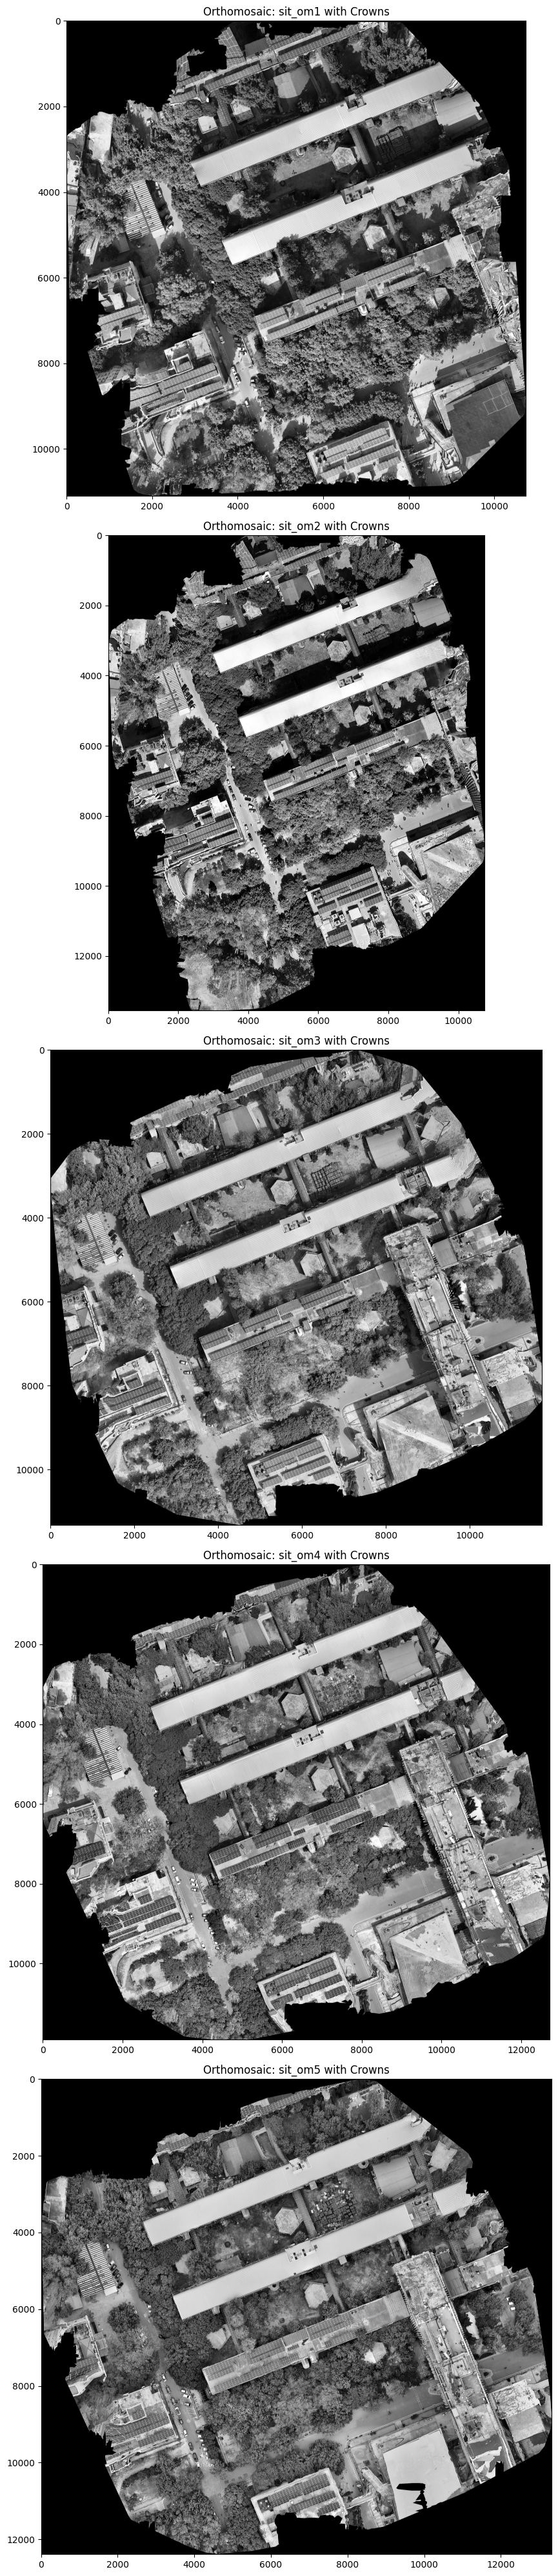

In [3]:
# Overlay Crowns on Orthomosaics
fig, axes = plt.subplots(len(orthomosaics), 1, figsize=(10, 8 * len(orthomosaics)))
if len(orthomosaics) == 1:
    axes = [axes]
for idx, (om_name, om) in enumerate(orthomosaics.items()):
    ax = axes[idx]
    img = om.read(1)
    ax.imshow(img, cmap='gray')
    crowns_gdf = crowns.get(om_name.replace('sit_', ''), None)
    if crowns_gdf is not None:
        crowns_gdf.boundary.plot(ax=ax, edgecolor='red')
    ax.set_title(f'Orthomosaic: {om_name} with Crowns')
plt.tight_layout()
plt.show()

In [4]:
# Assign Initial IDs to Crowns
crown_id_map = {}
for om_name, crowns_gdf in crowns.items():
    ids = [f'{om_name}_{i+1}' for i in range(len(crowns_gdf))]
    crowns_gdf['crown_id'] = ids
    crown_id_map[om_name] = ids
print('Assigned crown IDs:', crown_id_map)

Assigned crown IDs: {'OM1': ['OM1_1', 'OM1_2', 'OM1_3', 'OM1_4', 'OM1_5', 'OM1_6', 'OM1_7', 'OM1_8', 'OM1_9', 'OM1_10', 'OM1_11', 'OM1_12', 'OM1_13', 'OM1_14', 'OM1_15', 'OM1_16', 'OM1_17', 'OM1_18', 'OM1_19', 'OM1_20', 'OM1_21', 'OM1_22', 'OM1_23', 'OM1_24', 'OM1_25', 'OM1_26', 'OM1_27', 'OM1_28', 'OM1_29', 'OM1_30', 'OM1_31', 'OM1_32', 'OM1_33', 'OM1_34', 'OM1_35', 'OM1_36', 'OM1_37', 'OM1_38', 'OM1_39', 'OM1_40', 'OM1_41', 'OM1_42', 'OM1_43', 'OM1_44', 'OM1_45', 'OM1_46', 'OM1_47', 'OM1_48', 'OM1_49', 'OM1_50', 'OM1_51', 'OM1_52', 'OM1_53', 'OM1_54', 'OM1_55', 'OM1_56', 'OM1_57', 'OM1_58', 'OM1_59', 'OM1_60', 'OM1_61', 'OM1_62', 'OM1_63', 'OM1_64', 'OM1_65', 'OM1_66', 'OM1_67', 'OM1_68', 'OM1_69', 'OM1_70', 'OM1_71', 'OM1_72', 'OM1_73', 'OM1_74', 'OM1_75', 'OM1_76', 'OM1_77', 'OM1_78', 'OM1_79', 'OM1_80'], 'OM2': ['OM2_1', 'OM2_2', 'OM2_3', 'OM2_4', 'OM2_5', 'OM2_6', 'OM2_7', 'OM2_8', 'OM2_9', 'OM2_10', 'OM2_11', 'OM2_12', 'OM2_13', 'OM2_14', 'OM2_15', 'OM2_16', 'OM2_17', 'OM2_18', 

In [5]:
# Map Crowns to Corresponding Orthomosaic Images
crown_to_om_image = {}
for om_name, crowns_gdf in crowns.items():
    for idx, row in crowns_gdf.iterrows():
        crown_id = row['crown_id']
        crown_to_om_image[crown_id] = om_name
print('Crown to orthomosaic mapping:', list(crown_to_om_image.items())[:5])

Crown to orthomosaic mapping: [('OM1_1', 'OM1'), ('OM1_2', 'OM1'), ('OM1_3', 'OM1'), ('OM1_4', 'OM1'), ('OM1_5', 'OM1')]


In [6]:
# Process Crowns: Shifting and Merging
from shapely.affinity import translate

def shift_crown(crown_geom, x_shift, y_shift):
    return translate(crown_geom, xoff=x_shift, yoff=y_shift)

def merge_crowns(crown_geoms):
    from shapely.ops import unary_union
    return unary_union(crown_geoms)

# Example: shift and merge crowns (demo)
shifted_crowns = {}
merged_crowns = {}
for om_name, crowns_gdf in crowns.items():
    shifted_crowns[om_name] = crowns_gdf.copy()
    shifted_crowns[om_name]['geometry'] = crowns_gdf['geometry'].apply(lambda g: shift_crown(g, 1, 1))
    # For merging, just merge first two crowns as example
    if len(crowns_gdf) > 1:
        merged_geom = merge_crowns([crowns_gdf.iloc[0].geometry, crowns_gdf.iloc[1].geometry])
        merged_crowns[f'{om_name}_merged'] = merged_geom

In [7]:
# Store Photo Associations for Merged Crowns
merged_crown_photos = {}
for merged_id, merged_geom in merged_crowns.items():
    # Store both original photos for merged crowns
    om_name = merged_id.split('_merged')[0]
    merged_crown_photos[merged_id] = [om_name, om_name]  # Example: both from same orthomosaic
print('Merged crown photo associations:', merged_crown_photos)

Merged crown photo associations: {'OM1_merged': ['OM1', 'OM1'], 'OM2_merged': ['OM2', 'OM2'], 'OM3_merged': ['OM3', 'OM3'], 'OM4_merged': ['OM4', 'OM4'], 'OM5_merged': ['OM5', 'OM5']}


In [8]:
# Build Graph-Based Data Structure Using Crown IDs
G = nx.Graph()
# Add nodes for each crown
for om_name, crowns_gdf in crowns.items():
    for crown_id in crowns_gdf['crown_id']:
        G.add_node(crown_id, om=om_name)
# Example: add edges (tracking relationships)
# Here, just connect first two crowns in each orthomosaic as a demo
for om_name, crowns_gdf in crowns.items():
    if len(crowns_gdf) > 1:
        G.add_edge(crowns_gdf['crown_id'].iloc[0], crowns_gdf['crown_id'].iloc[1])
print('Graph nodes:', G.nodes())
print('Graph edges:', G.edges())

Graph nodes: ['OM1_1', 'OM1_2', 'OM1_3', 'OM1_4', 'OM1_5', 'OM1_6', 'OM1_7', 'OM1_8', 'OM1_9', 'OM1_10', 'OM1_11', 'OM1_12', 'OM1_13', 'OM1_14', 'OM1_15', 'OM1_16', 'OM1_17', 'OM1_18', 'OM1_19', 'OM1_20', 'OM1_21', 'OM1_22', 'OM1_23', 'OM1_24', 'OM1_25', 'OM1_26', 'OM1_27', 'OM1_28', 'OM1_29', 'OM1_30', 'OM1_31', 'OM1_32', 'OM1_33', 'OM1_34', 'OM1_35', 'OM1_36', 'OM1_37', 'OM1_38', 'OM1_39', 'OM1_40', 'OM1_41', 'OM1_42', 'OM1_43', 'OM1_44', 'OM1_45', 'OM1_46', 'OM1_47', 'OM1_48', 'OM1_49', 'OM1_50', 'OM1_51', 'OM1_52', 'OM1_53', 'OM1_54', 'OM1_55', 'OM1_56', 'OM1_57', 'OM1_58', 'OM1_59', 'OM1_60', 'OM1_61', 'OM1_62', 'OM1_63', 'OM1_64', 'OM1_65', 'OM1_66', 'OM1_67', 'OM1_68', 'OM1_69', 'OM1_70', 'OM1_71', 'OM1_72', 'OM1_73', 'OM1_74', 'OM1_75', 'OM1_76', 'OM1_77', 'OM1_78', 'OM1_79', 'OM1_80', 'OM2_1', 'OM2_2', 'OM2_3', 'OM2_4', 'OM2_5', 'OM2_6', 'OM2_7', 'OM2_8', 'OM2_9', 'OM2_10', 'OM2_11', 'OM2_12', 'OM2_13', 'OM2_14', 'OM2_15', 'OM2_16', 'OM2_17', 'OM2_18', 'OM2_19', 'OM2_20', 'OM2

In [9]:
# Show Time Series for Each Tracked Tree

def show_tracked_tree_time_series(G, crowns, tree_id):
    # Get connected component for the tree_id
    component = nx.node_connected_component(G, tree_id)
    print(f'Time series for tracked tree {tree_id}:', component)
    # Visualize crowns in time order
    fig, axes = plt.subplots(len(component), 1, figsize=(8, 5 * len(component)))
    if len(component) == 1:
        axes = [axes]
    for idx, cid in enumerate(sorted(component)):
        om_name = cid.split('_')[0]
        crowns_gdf = crowns[om_name]
        crown_row = crowns_gdf[crowns_gdf['crown_id'] == cid]
        if not crown_row.empty:
            crown_row.boundary.plot(ax=axes[idx], edgecolor='blue')
            axes[idx].set_title(f'Crown {cid} in {om_name}')
    plt.tight_layout()
    plt.show()

# Example usage:
# show_tracked_tree_time_series(G, crowns, list(G.nodes())[0])

In [10]:
# Display All Orthomosaics with Tracked Tree Boundaries

def display_all_orthomosaics_with_tracked_trees(G, crowns):
    tracked_trees = list(nx.connected_components(G))
    for om_name, om in orthomosaics.items():
        fig, ax = plt.subplots(figsize=(10, 8))
        img = om.read(1)
        ax.imshow(img, cmap='gray')
        crowns_gdf = crowns[om_name]
        for tree in tracked_trees:
            for cid in tree:
                if cid.startswith(om_name):
                    crown_row = crowns_gdf[crowns_gdf['crown_id'] == cid]
                    if not crown_row.empty:
                        crown_row.boundary.plot(ax=ax, edgecolor='green')
        ax.set_title(f'Orthomosaic: {om_name} with Tracked Tree Crowns')
        plt.show()

# Example usage:
# display_all_orthomosaics_with_tracked_trees(G, crowns)

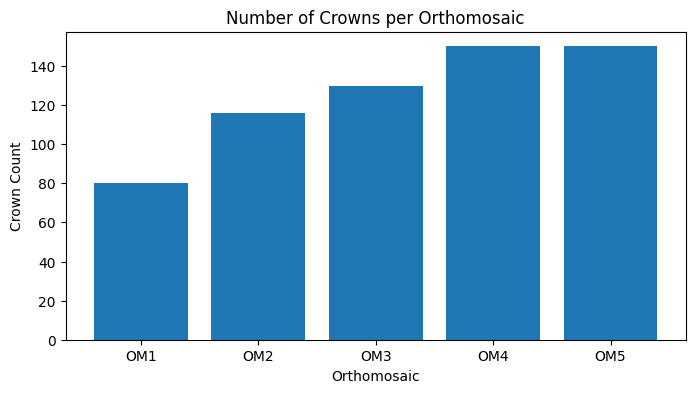

Total tracked trees (connected components): 621


In [11]:
# Additional Visualizations for Crown Tracking
# Example: Show number of crowns per orthomosaic and tracked trees
crown_counts = {om: len(crowns_gdf) for om, crowns_gdf in crowns.items()}
tracked_tree_counts = len(list(nx.connected_components(G)))

plt.figure(figsize=(8,4))
plt.bar(crown_counts.keys(), crown_counts.values())
plt.title('Number of Crowns per Orthomosaic')
plt.xlabel('Orthomosaic')
plt.ylabel('Crown Count')
plt.show()

print(f'Total tracked trees (connected components): {tracked_tree_counts}')

In [12]:
# Interactive Crown Processing: Shifting, Merging, and Updating
from shapely.affinity import translate
from shapely.ops import unary_union

def shift_crown_by_id(crowns, crown_id, x_shift, y_shift):
    om_name = crown_id.split('_')[0]
    crowns_gdf = crowns[om_name]
    idx = crowns_gdf[crowns_gdf['crown_id'] == crown_id].index
    if not idx.empty:
        crowns_gdf.at[idx[0], 'geometry'] = translate(crowns_gdf.at[idx[0], 'geometry'], xoff=x_shift, yoff=y_shift)
        print(f'Shifted {crown_id} by ({x_shift}, {y_shift})')
    else:
        print(f'Crown ID {crown_id} not found.')

def merge_crowns_by_ids(crowns, crown_ids, new_id):
    geoms = []
    om_names = set()
    for cid in crown_ids:
        om_name = cid.split('_')[0]
        om_names.add(om_name)
        crowns_gdf = crowns[om_name]
        row = crowns_gdf[crowns_gdf['crown_id'] == cid]
        if not row.empty:
            geoms.append(row.iloc[0].geometry)
    if geoms:
        merged_geom = unary_union(geoms)
        # Add merged crown to the first orthomosaic's GeoDataFrame
        first_om = list(om_names)[0]
        crowns[first_om] = crowns[first_om].append({'geometry': merged_geom, 'crown_id': new_id}, ignore_index=True)
        print(f'Merged crowns {crown_ids} into {new_id}')
        return new_id
    else:
        print('No valid crowns to merge.')
        return None

# Example usage:
# shift_crown_by_id(crowns, 'OM1_1', 5, 5)
# merge_crowns_by_ids(crowns, ['OM1_1', 'OM1_2'], 'OM1_merged_1')